# Preliminary direct numerical simulation of 2D Rayleigh-Bénard convection
In this notebook, I present the first Dedalus simulations and examine their qualitative features. The first aim is to choose the parameters for the fine-resolution run so that:
- The system displays turbulent convection and can thus be considered an an analogue for the chaotic dynamics of the atmosphere,
- The turbulent features of the flow are reasonably well resolved, so the data can be considered close to "truth", and
- The simulation is not prohibitively expensive to run.

I will then attempt to choose the parameters for the coarse-resolution run so that:
- It fails to resolve the small scales and displays qualitatively different behaviour in comparison to the fine-resolution run, but
- Despite this, the model is still stable and the resolution is not so poor that parametrisation would be hopeless.

## Theoretical formulation
I consider the nondimensionalised equations in the Boussinesq approximation given by [Busse (1978)](https://doi.org/10.1088/0034-4885/41/12/003):
$$
\begin{align*}
    \mathrm{Pr}^{-1} \left[\partial_t \vec{u} + (\vec{u} \cdot \nabla) \vec{u}\right] &= - \nabla \pi + \nabla^2 \vec{u} + \theta \hat{z}, \\
    \partial_t \theta + (\vec{u} \cdot \nabla) \theta &= \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \nabla^2 \theta, \\
    \nabla \cdot \vec{u} &= 0
\end{align*}
$$
where:
- $\vec{u} = (u,0,w)$ is the dimensionless velocity,
- $\theta$ is the dimensionless temperature perturbation from the conductive (linear) base profile,
- $\pi$ is the dimensionless pressure perturbation from the hydrostatic base profile,
- $\mathrm{Pr}$ is the Prandtl number, the ratio of kinematic viscosity to thermal diffisivity,
- $\mathrm{Ra}$ is the Rayleigh number, the ratio of the thermal diffusion time scale to the convective time scale.

The equations have been nondimensionalised using:
- The layer thickness $d$ as the length scale,
- The thermal diffusion time $d^2/D$, where $D$ is the thermal diffusivity, as the time scale, and
- A temperature perturbation scale $\delta T/\mathrm{Ra}$, where $\delta T$ is the temperature difference between the top and bottom plates.

I impose no-slip, isothermal boundary conditions at the top and bottom of the domain,
$$
\begin{alignat*}{2}
    \vec{u}(z=0) &= \vec{u}(z=L_z) &&= \vec{0}, \\
    \theta(z=0) &= \theta(z=L_z) &&= 0,
\end{alignat*}
$$
and periodic lateral boundary conditions
$$
\begin{align*}
    \vec{u}(x=0) &= \vec{u}(x=L_x),\\
    \theta(x=0) &= \theta(x=L_x).
\end{align*}
$$

### Tau terms
Dedalus requires us to add *tau terms* of the form $\tau(x) P(z)$, where $\tau$ is a new degree of freedom and $P$ is a known polynomial, to the equations. This allows the non-periodic top and bottom boundary conditions to be imposed while ensuring that the system still has exact polynomial solutions (i.e., so it is solvable using spectral methods). Following [the steps in the documentation](https://dedalus-project.readthedocs.io/en/latest/pages/tau_method.html), I introduce six new degrees of freedom
$$
    \vec{\tau}_{u1}(x) = (\tau_1(x), 0, \tau_2(x)), \quad \vec{\tau}_{u2}(x) = (\tau_3(x), 0, \tau_4(x)),
    \quad \tau_{\theta 1}(x), \quad \text{and } \tau_{\theta 2}(x).
$$
Defining the auxiliary variables
$$
\begin{align*}
    G_u &= \nabla \otimes \vec{u} - \hat{z} \otimes \vec{\tau}_{u1}(x) P(z), \\
    \vec{G}_\theta &= \nabla \theta - \hat{z} \tau_{\theta 1}(x) P(z),
\end{align*}
$$
the equations become
$$
\begin{align*}
    \mathrm{Pr}^{-1} \partial_t \vec{u} - \nabla \cdot G_u + \nabla \pi - \theta \hat{z} + \vec{\tau}_{u2}(x) P(z) &= -\mathrm{Pr}^{-1} \vec{u} \cdot G_u, \\
    \partial_t \theta - \nabla \cdot \vec{G}_\theta - \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \tau_{\theta 2}(x) P(z) &= -\vec{u} \cdot \vec{G}_\theta, \\
    \operatorname{Tr}(G_u) &= 0.
\end{align*}
$$

### Pressure gauge condition
Since only the gradient of $\pi$ appears in the equations, there is a gauge freedom in the problem: the pressure is only determined up to a constant. Dedalus requires us to explicitly specify gauge conditions, so since $\pi$ is a pressure perturbation, I require its mean value to be zero:
$$\int \pi ~\mathrm{d}V = 0.$$
Following [the documentation](https://dedalus-project.readthedocs.io/en/latest/pages/gauge_conditions.html), I must also introduce a seventh spatially constant tau variable $\tau_\pi$ to the divergence equation:
$$\operatorname{Tr}(G_u) + \tau_\pi = 0.$$

### Final PDE system
The final system of equations that I have entered into Dedalus is
$$
\begin{align*}
    \mathrm{Pr}^{-1} \partial_t \vec{u} - \nabla \cdot G_u + \nabla \pi - \theta \hat{z} + \vec{\tau}_{u2}(x) P(z) &= -\mathrm{Pr}^{-1} \vec{u} \cdot G_u, \\
    \partial_t \theta - \nabla \cdot \vec{G}_\theta - \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \tau_{\theta 2}(x) P(z) &= -\vec{u} \cdot \vec{G}_\theta, \\
    \operatorname{Tr}(G_u) + \tau_\pi = 0,
\end{align*}
$$
with the substitutions
$$
\begin{align*}
    G_u &= \nabla \otimes \vec{u} - \hat{z} \otimes \vec{\tau}_{u1}(x) P(z), \\
    \vec{G}_\theta &= \nabla \theta - \hat{z} \tau_{\theta 1}(x) P(z),
\end{align*}
$$
subject to the boundary conditions
$$
\begin{alignat*}{2}
    \vec{u}(z=0) &= \vec{u}(z=L_z) &&= \vec{0}, \\
    \theta(z=0) &= \theta(z=L_z) &&= 0, \\
    \int \pi ~\mathrm{d}V &= 0. && \\
\end{alignat*}
$$
The periodic lateral boundaries are handled automatically by using a Fourier basis in the horizontal.

## Implementation and analysis
I have adapted the code from [this example notebook](https://dedalus-project.readthedocs.io/en/latest/pages/examples/ivp_2d_rayleigh_benard.html) for 2D RBC in the Dedalus documentation.

The choice of parameters is informed by the scales used to nondimensionalise the equations:
- The dimensionless length unit is the layer thickness $d$, so the height of the domain must be 1 and the width should be greater than 1 but still on the order of unity,
- The time unit is the thermal diffusion time, which is $\mathrm{Ra}$ times larger than the convective time scale, so in order to resolve convective motions the time step should be on the order of $1/\mathrm{Ra}$,
- Convective instability only occurs for sufficiently large Rayleigh numbers ($\gtrsim 10^3$ for most cases in the literature).

The fluid is initially at rest, with a random, normally distributed temperature perturbation at each point. Since the dimensionless temperature unit is $\delta T/\mathrm{Ra}$ and one expects the solution to have temperature variations on the order of $\delta T$, the initial perturbation should be a few orders of magnitude smaller than $\mathrm{Ra}$.

In [130]:
from IPython.display import Video
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

### Fine resolution run #1
This run has:
- Aspect ratio 4
- $\mathrm{Ra} = 10^6$
- $\mathrm{Pr} = 1$
- 256 horizontal modes
- 64 vertical modes
- Time step $1/\mathrm{Ra} = 10^{-6}$
- Simulation length $10^{-1}$ time units

Observe that while the flow is initially unsteady, the transient behaviour diminishes and the system converges to a stable periodic solution with four convective cells after about 0.03 time units.

In [99]:
Video('../data/prelim_dns_fine/prelim_dns_fine_s1.mp4')

### Fine resolution run #2
I now increase the Rayleigh number by a factor of 10 while keeping the same time step:
- Aspect ratio 4
- $\mathrm{Ra} = 10^7$
- $\mathrm{Pr} = 1$
- 256 horizontal modes
- 64 vertical modes
- Time step $10/\mathrm{Ra} = 10^{-6}$
- Simulation length $10^{-1}$ time units

The flow now reaches a slightly less steady state.

In [132]:
Video('../data/prelim_dns_fine2/prelim_dns_fine2_s1.mp4')

### Fine resolution run #3
I now increase the Rayleigh number by another factor of 10:
- Aspect ratio 4
- $\mathrm{Ra} = 10^8$
- $\mathrm{Pr} = 1$
- 256 horizontal modes
- 64 vertical modes
- Time step $10/\mathrm{Ra} = 10^{-7}$
- Simulation length $10^{-2}$ time units

The system is now beginning to exhibit the desired properties. After the initial transients have disappeared, there is still turbulent fine-scale motion superimposed on the large-scale circulation.

In [15]:
Video('../data/prelim_dns_fine3_new/prelim_dns_fine3_new_s1.mp4')

Are the fields spatially well-resolved? Let's examine the data in coefficient space at the last time step.

In [144]:
data = xr.open_dataset('../data/prelim_dns_fine3_new/prelim_dns_fine3_new_s1.nc')
coef_theta = data.coef_theta.isel(t=-1)
coef_u = data.coef_u.isel(t=-1)
coef_w = data.coef_w.isel(t=-1)

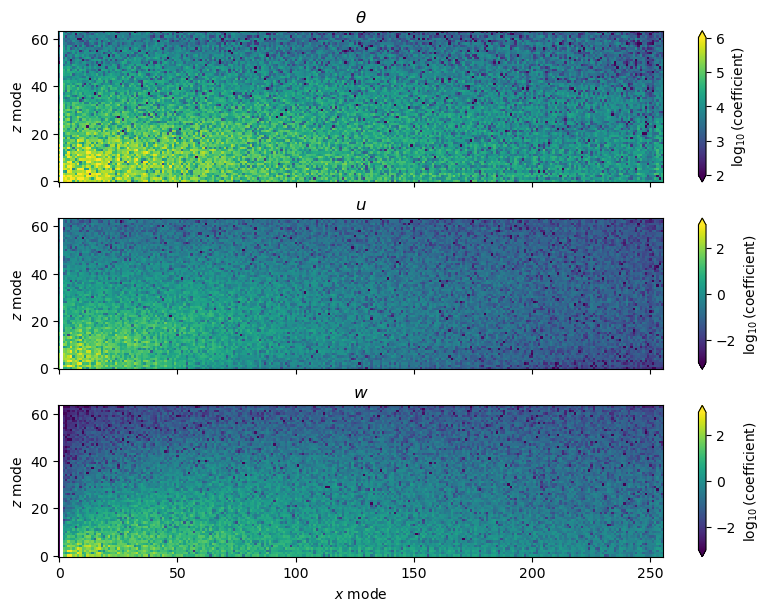

In [229]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, constrained_layout=True)

mesh = axes[0].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_theta)).T)
mesh.set_clim(2, 6)
axes[0].set_aspect('equal')
axes[0].set(title='$\\theta$', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[0], extend='both', label='$\\log_{{10}}$(coefficient)')

mesh = axes[1].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_u)).T)
mesh.set_clim(-3, 3)
axes[1].set_aspect('equal')
axes[1].set(title='$u$', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[1], extend='both', label='$\\log_{{10}}$(coefficient)')

mesh = axes[2].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_w)).T)
mesh.set_clim(-3, 3)
axes[2].set_aspect('equal')
axes[2].set(title='$w$', xlabel='$x$ mode', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[2], extend='both', label='$\\log_{{10}}$(coefficient)')

The coefficients of the highest modes are 3-4 orders of magnitude smaller than those of the lowest modes. This is reasonable, but the resolution could still be improved.

To determine whether the time step is suitable, we calculate the Courant number (the velocity in units of grid-boxes per time step):
$$
    C = \frac{|u| \Delta t}{\Delta x} + \frac{|w| \Delta t}{\Delta z}
$$
where $\Delta t$ is the time step and $\Delta x, \Delta z$ are the spatial resolutions. The CFL condition requires $C \lesssim 1$ for model stability, i.e.
$$
    \Delta t \lesssim \left( \frac{u}{\Delta x} + \frac{w}{\Delta z} \right)^{-1}.
$$
Below is a plot of the Courant number across the domain at the last time step.

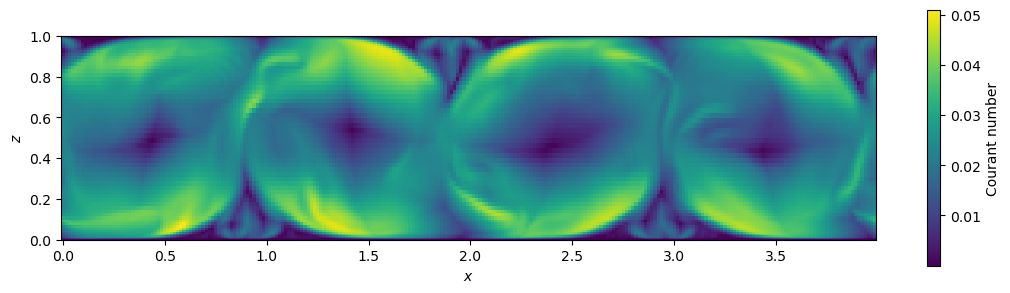

In [215]:
diff_x = np.diff(data.x)
dx = (
    np.concatenate([[diff_x[0]], diff_x])
    + np.concatenate([diff_x, [diff_x[-1]]])
)/2
diff_z = np.diff(data.z)
dz = (
    np.concatenate([[diff_z[0]], diff_z])
    + np.concatenate([diff_z, [diff_z[-1]]])
)/2
courant = (
    np.abs(data.u)/np.atleast_2d(dx).T
    + np.abs(data.w)/np.atleast_2d(dz)
)*data.timestep[0]

fig, ax = plt.subplots(figsize=(11, 3))
mesh = ax.pcolormesh(data.x, data.z, courant.isel(t=-1).T)
fig.colorbar(mesh, ax=ax, label='Courant number')
ax.set(aspect='equal', xlabel='$x$', ylabel='$z$')
fig.tight_layout()

Observe that the maximum value of $C$ is about 0.05, indicating that the time step is suitable (and could even be doubled to speed up the model).

### Fine resolution run #4
In light of the above analysis, I double the spatial resolution and the time step:
- Aspect ratio 4
- $\mathrm{Ra} = 10^8$
- $\mathrm{Pr} = 1$
- 512 horizontal modes
- 128 vertical modes
- Time step $20/\mathrm{Ra} = 2 \times 10^{-7}$
- Simulation length $10^{-2}$ time units

In [232]:
Video('../data/prelim_dns_fine4/prelim_dns_fine4_s1.mp4')

Again we may check the variables in coefficient space at the last time step:

In [230]:
data = xr.open_dataset('../data/prelim_dns_fine4/prelim_dns_fine4_s1.nc')
coef_theta = data.coef_theta.isel(t=-1)
coef_u = data.coef_u.isel(t=-1)
coef_w = data.coef_w.isel(t=-1)

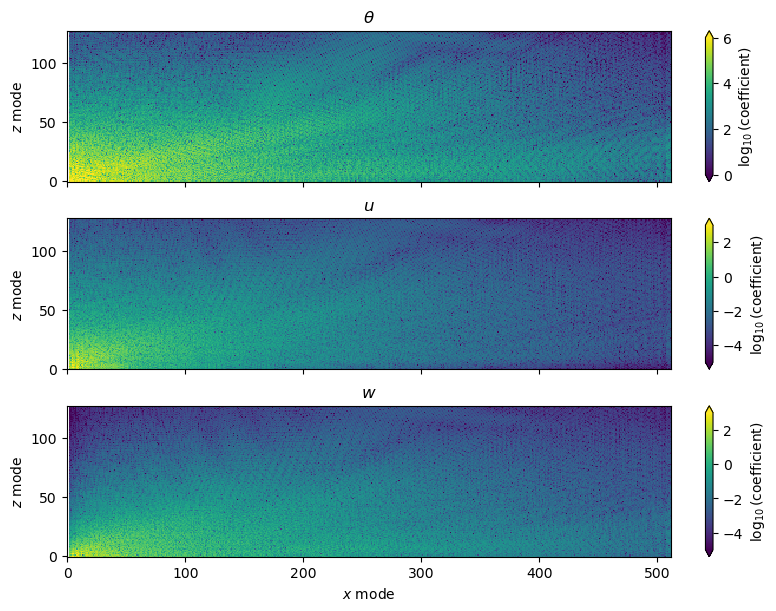

In [234]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, constrained_layout=True)

mesh = axes[0].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_theta)).T)
mesh.set_clim(0, 6)
axes[0].set_aspect('equal')
axes[0].set(title='$\\theta$', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[0], extend='both', label='$\\log_{{10}}$(coefficient)')

mesh = axes[1].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_u)).T)
mesh.set_clim(-5, 3)
axes[1].set_aspect('equal')
axes[1].set(title='$u$', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[1], extend='both', label='$\\log_{{10}}$(coefficient)')

mesh = axes[2].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_w)).T)
mesh.set_clim(-5, 3)
axes[2].set_aspect('equal')
axes[2].set(title='$w$', xlabel='$x$ mode', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[2], extend='both', label='$\\log_{{10}}$(coefficient)')

Now the coefficients of the highest modes are ~6 orders of magnitude smaller than those of the lowest modes, indicating that the flow is better resolved. This is also evident from inspection of the real-space animation above.

Now for the Courant number at the last time step:

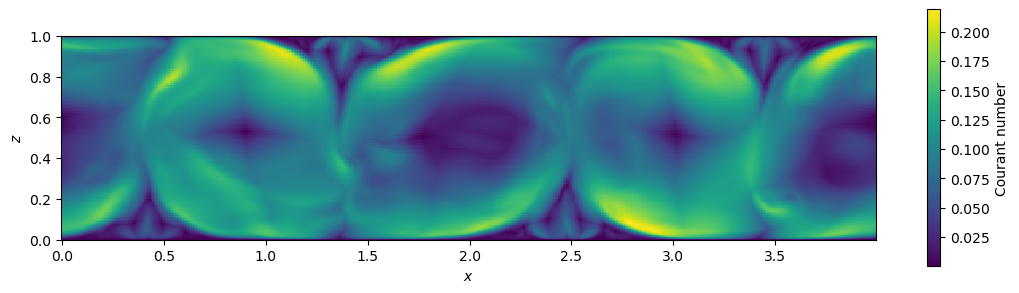

In [235]:
diff_x = np.diff(data.x)
dx = (
    np.concatenate([[diff_x[0]], diff_x])
    + np.concatenate([diff_x, [diff_x[-1]]])
)/2
diff_z = np.diff(data.z)
dz = (
    np.concatenate([[diff_z[0]], diff_z])
    + np.concatenate([diff_z, [diff_z[-1]]])
)/2
courant = (
    np.abs(data.u)/np.atleast_2d(dx).T
    + np.abs(data.w)/np.atleast_2d(dz)
)*data.timestep[0]

fig, ax = plt.subplots(figsize=(11, 3))
mesh = ax.pcolormesh(data.x, data.z, courant.isel(t=-1).T)
fig.colorbar(mesh, ax=ax, label='Courant number')
ax.set(aspect='equal', xlabel='$x$', ylabel='$z$')
fig.tight_layout()

Doubling the time step has increased the maximum Courant number to about 0.2. This is still safely smaller than 1, so we have made a reasonable compromise.

### Coarse resolution run #1
I now turn my attention to coarse simulations at the same Rayleigh number, the first of which has the following parameters:
- Aspect ratio 4
- $\mathrm{Ra} = 10^8$
- $\mathrm{Pr} = 1$
- 128 horizontal modes
- 32 vertical modes
- Time step $100/\mathrm{Ra} = 10^{-6}$
- Simulation length $10^{-2}$ time units

Now the steady state has 6 convective cells instead of 4! The change of resolution has affected the large-scale circulation.

In [236]:
Video('../data/prelim_dns_coarse1/prelim_dns_coarse1_s1.mp4')

Examining the data in coefficient space, we see that the difference in magnitude between the highest and lowest modes is now only 2-3 orders of magnitude, so the flow is poorly resolved.

In [239]:
data = xr.open_dataset('../data/prelim_dns_coarse1/prelim_dns_coarse1_s1.nc')
coef_theta = data.coef_theta.isel(t=-1)
coef_u = data.coef_u.isel(t=-1)
coef_w = data.coef_w.isel(t=-1)

/srv/ccrc/AtmSS/z5310829/miniconda3/envs/hons/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


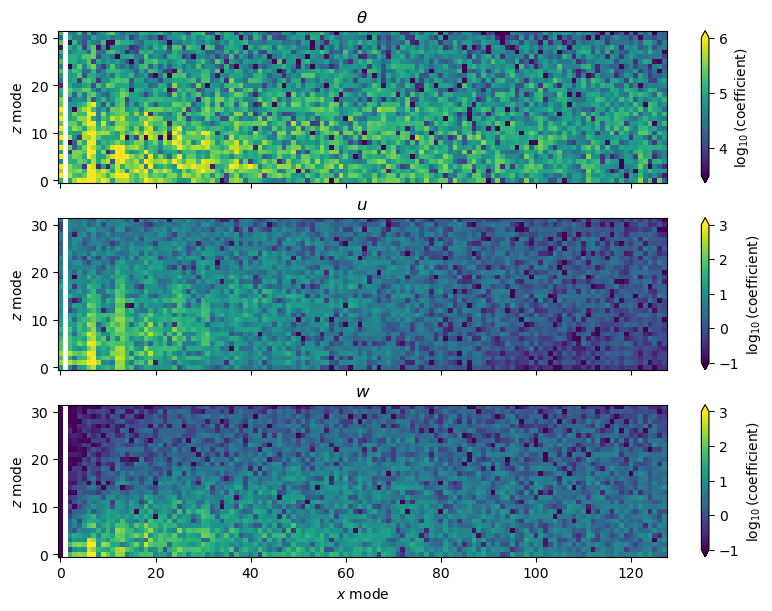

In [242]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, constrained_layout=True)

mesh = axes[0].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_theta)).T)
mesh.set_clim(3.5, 6)
axes[0].set_aspect('equal')
axes[0].set(title='$\\theta$', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[0], extend='both', label='$\\log_{{10}}$(coefficient)')

mesh = axes[1].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_u)).T)
mesh.set_clim(-1, 3)
axes[1].set_aspect('equal')
axes[1].set(title='$u$', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[1], extend='both', label='$\\log_{{10}}$(coefficient)')

mesh = axes[2].pcolormesh(data.kx, data.kz, np.log10(np.abs(coef_w)).T)
mesh.set_clim(-1, 3)
axes[2].set_aspect('equal')
axes[2].set(title='$w$', xlabel='$x$ mode', ylabel='$z$ mode')
fig.colorbar(
    mesh, ax=axes[2], extend='both', label='$\\log_{{10}}$(coefficient)')

The maximum Courant number is slightly larger than before, but still well below 1 (the threshold for model stability).

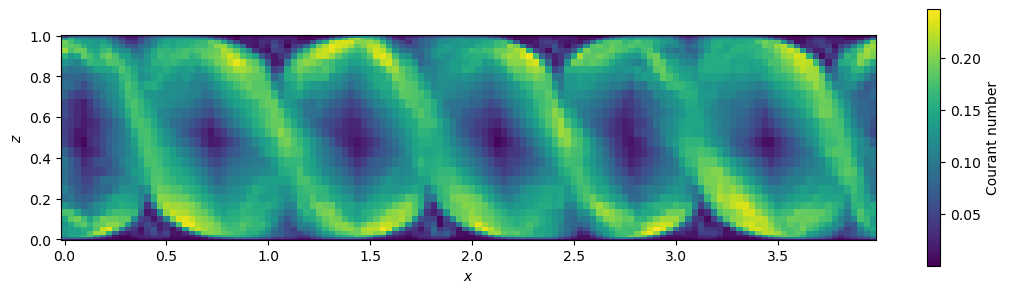

In [246]:
diff_x = np.diff(data.x)
dx = (
    np.concatenate([[diff_x[0]], diff_x])
    + np.concatenate([diff_x, [diff_x[-1]]])
)/2
diff_z = np.diff(data.z)
dz = (
    np.concatenate([[diff_z[0]], diff_z])
    + np.concatenate([diff_z, [diff_z[-1]]])
)/2
courant = (
    np.abs(data.u)/np.atleast_2d(dx).T
    + np.abs(data.w)/np.atleast_2d(dz)
)*data.timestep[0]

fig, ax = plt.subplots(figsize=(11, 3))
mesh = ax.pcolormesh(data.x, data.z, courant.isel(t=-1).T)
fig.colorbar(mesh, ax=ax, label='Courant number')
ax.set(aspect='equal', xlabel='$x$', ylabel='$z$')
fig.tight_layout()

## Conclusions
I am able to draw the following conclusions regarding the choice of parameters from the above analysis:
- Aspect ratio: It seems unlikely that this would have much bearing on parametrisation. 4 seems to be sufficiently thin.
- Rayleigh number: The runs in this notebook demonstrate that $\mathrm{Ra} \sim 10^8$ is necessary for fully turbulent convection.
- Time step:
    - For fine runs, the model is stable with $\Delta t = 2 \times 10^{-7}$, for which $C_\mathrm{max} \sim 0.2$.
    - For coarse runs, $\Delta t = 10^{-6}$ results in a similar Courant number. It is not yet clear whether or not this should be increased further.
- Spatial resolution:
    - For fine runs, 512 x 128 resolves the small features of the flow well.
    - For coarse runs, reducing the resolution to 128 x 32 is enough to significantly change the large-scale flow. This will likely need further adjustment once I begin experimenting with parametrisation.
- Simulation length: this will probably need to be increased to provide enough training data to fit a good regression model, and enough evaluation data to assess its accuracy.